# Import modules

In [124]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import sys
sys.path.append('../')
from src.config import *
from src.helper_visualization import *
from src.helper_pred import *

# Load Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90197 entries, 0 to 90196
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        90197 non-null  int64 
 1   Title             90197 non-null  object
 2   Product Name      90197 non-null  object
 3   Title_Processed   90197 non-null  object
 4   Language          90197 non-null  object
 5   Length            90197 non-null  int64 
 6   Title_Translated  90197 non-null  object
 7   Title_Enhanced    90197 non-null  object
 8   Tags              90197 non-null  object
dtypes: int64(2), object(7)
memory usage: 6.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10022 entries, 0 to 10021
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        10022 non-null  int64 
 1   Title             10022 non-null  object
 2   Product Name      10022 non-null  

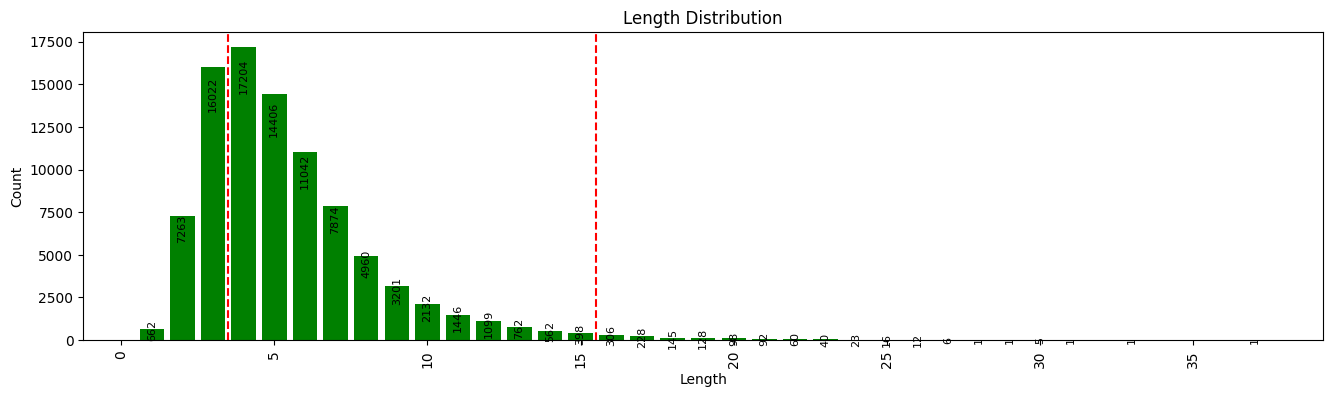

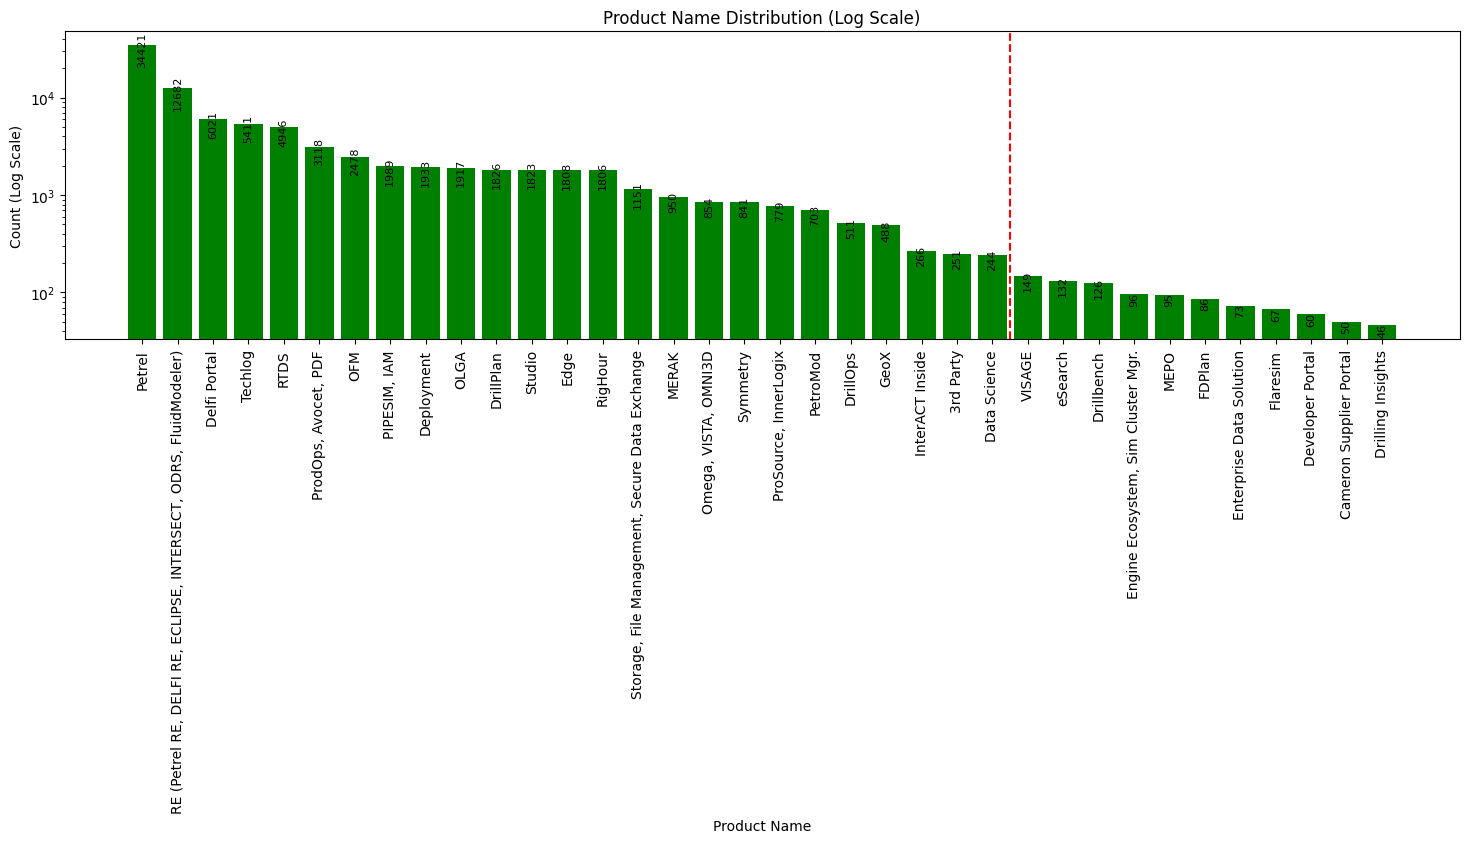

In [253]:
# Define global variables
TITLE_WORDS_MIN = 4
TITLE_WORDS_MAX = 15
LONGTAIL_CUTOFF = 200

TEXT_COL = 'Title_Enhanced'
TARGET_COL = 'Product Name'

PRODUCT_SIZE_MAX_TRAIN = 4000
PRODUCT_SIZE_MAX_TEST = 300
MAX_FEATURES = 20000

if 'df_train' not in locals():
    excel_file_train = f'{DATA_FOLDER_PATH_PROCESSED}/data_train.xlsx'
    df_train = pd.read_excel(excel_file_train)
    excel_file_test = f'{DATA_FOLDER_PATH_PROCESSED}/data_test.xlsx'
    df_test = pd.read_excel(excel_file_test)

print(df_train.info())
print(df_test.info())
hist_by_labels(df_train, 'Length', log=False, left=TITLE_WORDS_MIN-.5, right=TITLE_WORDS_MAX+.5)
hist_by_labels(df_train, 'Product Name', log=True, right=24.5)

In [186]:
df_train.head()

,Request ID,Title,Product Name,Title_Processed,Language,Length,Title_Translated,Title_Enhanced,Tags
0,1699372,[Ext] Excel To PEEP loader license for 2023,MERAK,Excel To PEEP loader license for,en,4,Excel To PEEP loader license for,Excel PEEP loader license,loader excel license peep
1,551469,Consulta de Techlog Connector For Studio,Petrel,Consulta de Techlog Connector For Studio,en,5,Consulta de Techlog Connector For Studio,Consulta de Techlog Connector Studio,connector de consulta studio techlog
2,1789618,RE: TPAO InterACT admin role,InterACT Inside,TPAO InterACT admin role,en,3,TPAO InterACT admin role,InterACT admin role,interact role admin
3,1294141,IWC Saudi <AAdy@slb.com> NAO BP Deepwater bit ...,RigHour,IWC Saudi NAO BP Deepwater bit size and Casing...,en,10,IWC Saudi NAO BP Deepwater bit size and Casing...,integrated well construction ( IWC ) NAO Deepw...,integrated casing nao construction bit deepwat...
4,1195512,Wells disappeared from wells Section.,"ProdOps, Avocet, PDF",Wells disappeared from wells Section.,en,4,Wells disappeared from wells Section.,Wells disappeared wells Section,well disappeared section


# Train/Test Datasets

Pipeline Construction

In [250]:
from sklearn.base import BaseEstimator, TransformerMixin

# create a scikit-learn transformer to remove the title with less than 3 words or more than 20 words
class TitleLengthFilter(BaseEstimator, TransformerMixin):
    def __init__(self, min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX):
        self.min_words = min_words
        self.max_words = max_words
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        df = df[df['Length'] >= self.min_words]
        df = df[df['Length'] <= self.max_words]
        df = df.reset_index(drop=True)
        return df

# create a scikit-learn transformer to combine the products which have less than 200 samples into one product
class LongTailCombiner(BaseEstimator, TransformerMixin):
    def __init__(self, min_samples=200, target_col=TARGET_COL):
        self.min_samples = min_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        long_tails = counts.index[counts < self.min_samples]
        mask = df[self.target_col].isin(long_tails)
        df.loc[mask, self.target_col]='Long Tail'
        return df

# create a scikit-learn transformer to cap the number of samples for each product
class SampleCapper(BaseEstimator, TransformerMixin):
    def __init__(self, max_samples=200, target_col=TARGET_COL):
        self.max_samples = max_samples
        self.target_col = target_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        df = X.copy()
        counts = df[self.target_col].value_counts()
        over_sampled = counts.index[counts > self.max_samples]
        # mask = df[self.target_col].isin(over_sampled)
        # df = df.drop(df[mask].sample(frac=1-self.max_samples/len(df)).index)
        for item in over_sampled:
            size = len(df[df[self.target_col]==item])
            df = df.drop(df[df[self.target_col]==item].sample(frac=1-self.max_samples/size).index)
        return df
    
    # create a scikit-learn pipeline to remove the title with less than 3 words or more than 20 words
from sklearn.pipeline import Pipeline

pipleline_data_prep_train = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TRAIN, target_col=TARGET_COL)),
    # ('text_vectorizer', TextVectorizer(vectorizer=vectorizer))
])

pipleline_data_prep_test = Pipeline([
    ('title_length_filter', TitleLengthFilter(min_words=TITLE_WORDS_MIN, max_words=TITLE_WORDS_MAX)),
    ('long_tail_product_combiner', LongTailCombiner(min_samples=LONGTAIL_CUTOFF*12//100, target_col=TARGET_COL)),
    ('sample_capper', SampleCapper(max_samples=PRODUCT_SIZE_MAX_TEST, target_col=TARGET_COL)),
    # ('text_vectorizer', TextVectorizer(vectorizer=vectorizer))
])
display(pipleline_data_prep_train)
display(pipleline_data_prep_test)

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner', LongTailCombiner()),
                ('sample_capper', SampleCapper(max_samples=4000))])

Pipeline(steps=[('title_length_filter', TitleLengthFilter()),
                ('long_tail_product_combiner',
                 LongTailCombiner(min_samples=24)),
                ('sample_capper', SampleCapper(max_samples=300))])

Data Processing

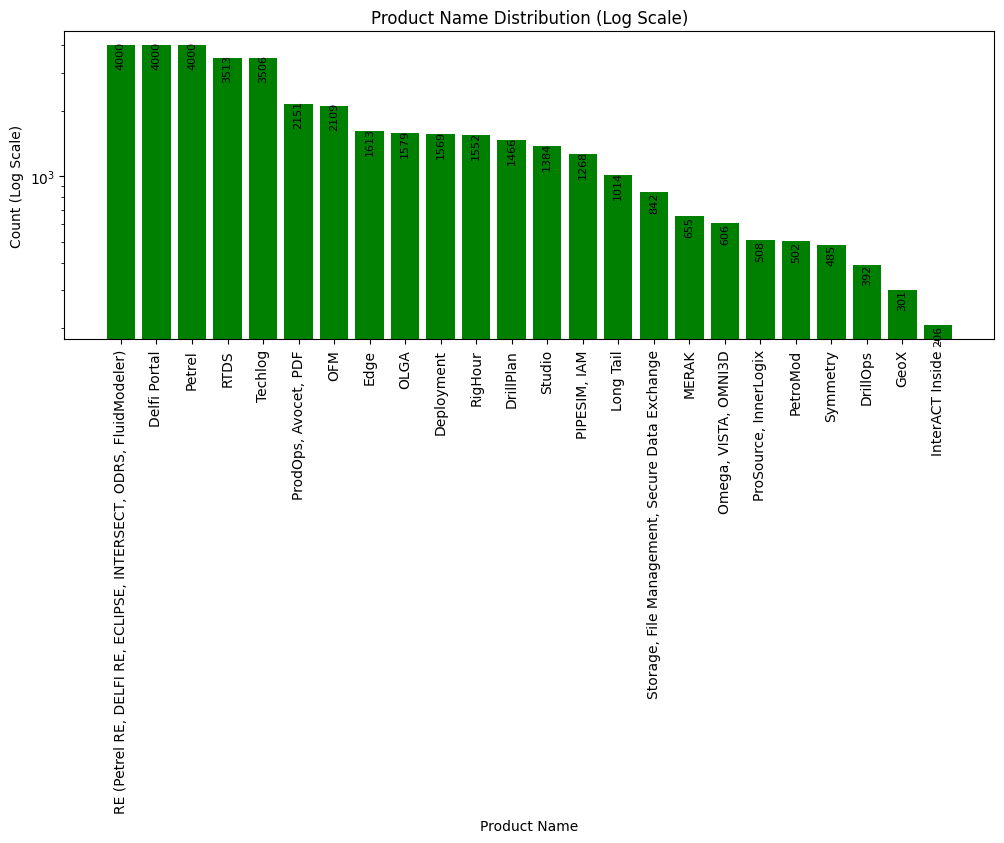

<class 'pandas.core.frame.DataFrame'>
Index: 39221 entries, 0 to 65085
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        39221 non-null  int64 
 1   Title             39221 non-null  object
 2   Product Name      39221 non-null  object
 3   Title_Processed   39221 non-null  object
 4   Language          39221 non-null  object
 5   Length            39221 non-null  int64 
 6   Title_Translated  39221 non-null  object
 7   Title_Enhanced    39221 non-null  object
 8   Tags              39221 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.0+ MB


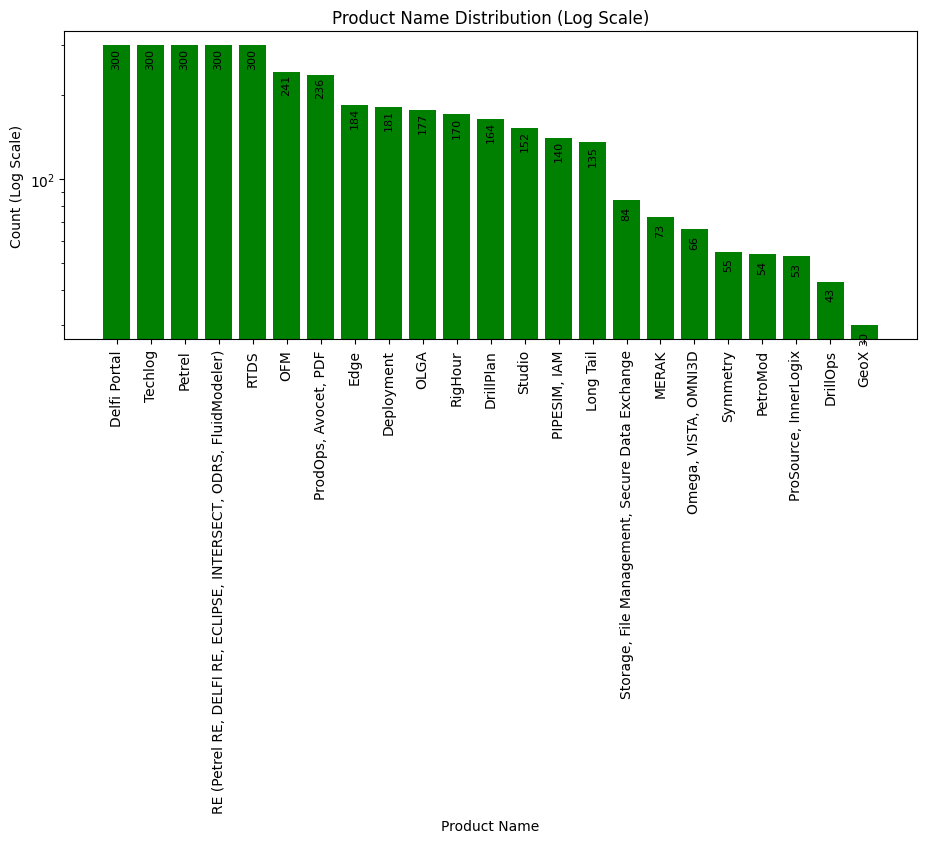

<class 'pandas.core.frame.DataFrame'>
Index: 3738 entries, 1 to 7244
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Request ID        3738 non-null   int64 
 1   Title             3738 non-null   object
 2   Product Name      3738 non-null   object
 3   Title_Processed   3738 non-null   object
 4   Language          3738 non-null   object
 5   Length            3738 non-null   int64 
 6   Title_Translated  3738 non-null   object
 7   Title_Enhanced    3738 non-null   object
 8   Tags              3738 non-null   object
dtypes: int64(2), object(7)
memory usage: 292.0+ KB


In [251]:
train_data = pipleline_data_prep_train.fit_transform(df_train)
hist_by_labels(train_data, 'Product Name', log=True, horizontal=True)
train_data.info()

test_data = pipleline_data_prep_test.fit_transform(df_test)
hist_by_labels(test_data, 'Product Name', log=True, horizontal=True)
test_data.info()

# Model Baseline - Cross Validation

In [134]:
# SciKit-Learn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

# Optuna
import optuna
import optuna.visualization as vis

# Others
import pickle

In [254]:
# create vectorizer for text
vectorizer_countvec = CountVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))
vectorizer_tfidf = TfidfVectorizer(max_features=MAX_FEATURES, analyzer='word', ngram_range=(1, 2))

X = df_train[TEXT_COL]
vectorizer_countvec.fit(X)
vectorizer_tfidf.fit(X)

vectorizer = vectorizer_tfidf

X_train = train_data[TEXT_COL]
y_train = train_data[TARGET_COL]
X_train_encoded = vectorizer.transform(X_train)

X_test = test_data[TEXT_COL]
X_test_encoded = vectorizer.transform(X_test)
y_test = test_data[TARGET_COL]

models = {
    'SGDClassifier': SGDClassifier(max_iter=5000),
    'SVC linear': SVC(kernel='linear'),
    'LogisticRegression': LogisticRegression(max_iter=5000),
    # 'RandomForestClassifier': RandomForestClassifier(),
    # 'GradientBoostingClassifier': GradientBoostingClassifier(),
    # 'MultinomialNB': MultinomialNB(),
    # 'SVC rbf': SVC(kernel='rbf'),
}

print('Baseline Score(s) of each model are ....')

for model in models:
    cv_result = cross_val_score(
        models[model], 
        X_train_encoded,
        y_train, #the target
        cv=5, 
        scoring='accuracy', # lease revise to the appropriate score
        n_jobs=-1
    )
    print(f'Average score: \033[94m{"{:.4f}".format(np.mean(cv_result))}\033[0m by \033[94m{model}\033[0m.')

Baseline Score(s) of each model are ....
Average score: 0.8149 by SGDClassifier.
Average score: 0.8148 by SVC linear.
Average score: 0.8004 by LogisticRegression.


In [ ]:
# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8206 by SGDClassifier.
# Average score: 0.8121 by SVC linear.
# Average score: 0.8018 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8196 by SGDClassifier.
# Average score: 0.8108 by SVC linear.
# Average score: 0.7994 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=3, TITLE_WORDS_MAX = 15 Title_Translated
# Average score: 0.8091 by SGDClassifier.
# Average score: 0.8030 by SVC linear.
# Average score: 0.7921 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=4, TITLE_WORDS_MAX = 15 Title_Enhanced
# Baseline Score(s) of each model are .... 3000 samples per product max
# Average score: 0.8144 by SGDClassifier.
# Average score: 0.8134 by SVC linear.
# Average score: 0.8013 by LogisticRegression.

# Average score: 0.8150 by SGDClassifier.  2000 samples per product max
# Average score: 0.8098 by SVC linear.
# Average score: 0.7996 by LogisticRegression.

# Baseline Score(s) of each model are .... TITLE_WORDS_MIN=3, TITLE_WORDS_MAX = 15 Title_Enhanced
# Average score: 0.8050 by SGDClassifier.
# Average score: 0.8021 by SVC linear.
# Average score: 0.7909 by LogisticRegression.

# Hpyerparameter Tuning

## SGC Classifier (2min)

In [193]:
# Clean up the study if it exists
study_name = 'sgd_classifier'
storage_name = 'sqlite:///optuna_study.db'

try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [213]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e-3, log=True),
        'eta0': trial.suggest_float('eta0', 1e-3, 1e-1, log=True),
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'optimal', 'adaptive']), #
        'max_iter': 10000,
        'random_state': 42
        }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    sgd_classifier = SGDClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(sgd_classifier, X_train_encoded, y_train, cv=5, scoring='accuracy')
    
    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=100, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_sore = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Score:", best_sore)

[I 2023-10-30 21:08:45,447] Using an existing study with name 'sgd_classifier' instead of creating a new one.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-10-30 21:09:01,943] Trial 401 finished with value: 0.8192841964889317 and parameters: {'alpha': 2.5033131371584387e-06, 'eta0': 0.02923760080825987, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 393 with value: 0.8260974166287716.
[I 2023-10-30 21:09:02,170] Trial 406 finished with value: 0.8256966819485244 and parameters: {'alpha': 9.15036569668422e-05, 'eta0': 0.02968414510800851, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 393 with value: 0.8260974166287716.
[I 2023-10-30 21:09:02,265] Trial 402 finished with value: 0.8256298872582366 and parameters: {'alpha': 9.20205911779116e-05, 'eta0': 0.02976864723017555, 'loss': 'modified_huber', 'penalty': 'l2', 'learning_rate': 'adaptive'}. Best is trial 393 with value: 0.8260974166287716.
[I 2023-10-30 21:09:02,324] Trial 409 finished with value: 0.825897026980995 and parameters: {'alpha': 8.888563758822369e-05, 'eta0': 0.039019368324701806, 'loss': 

In [214]:
vis.plot_optimization_history(study)

In [215]:
vis.plot_slice(study)

Accuracy: 0.828518
                                                                  precision    recall  f1-score   support

                                                    Delfi Portal      0.750     0.680     0.713       300
                                                      Deployment      0.732     0.680     0.705       181
                                                        DrillOps      0.882     0.698     0.779        43
                                                       DrillPlan      0.780     0.866     0.821       164
                                                            Edge      0.989     0.995     0.992       184
                                                            GeoX      0.893     0.833     0.862        30
                                                 InterACT Inside      0.000     0.000     0.000         0
                                                       Long Tail      0.644     0.496     0.561       135
                          

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



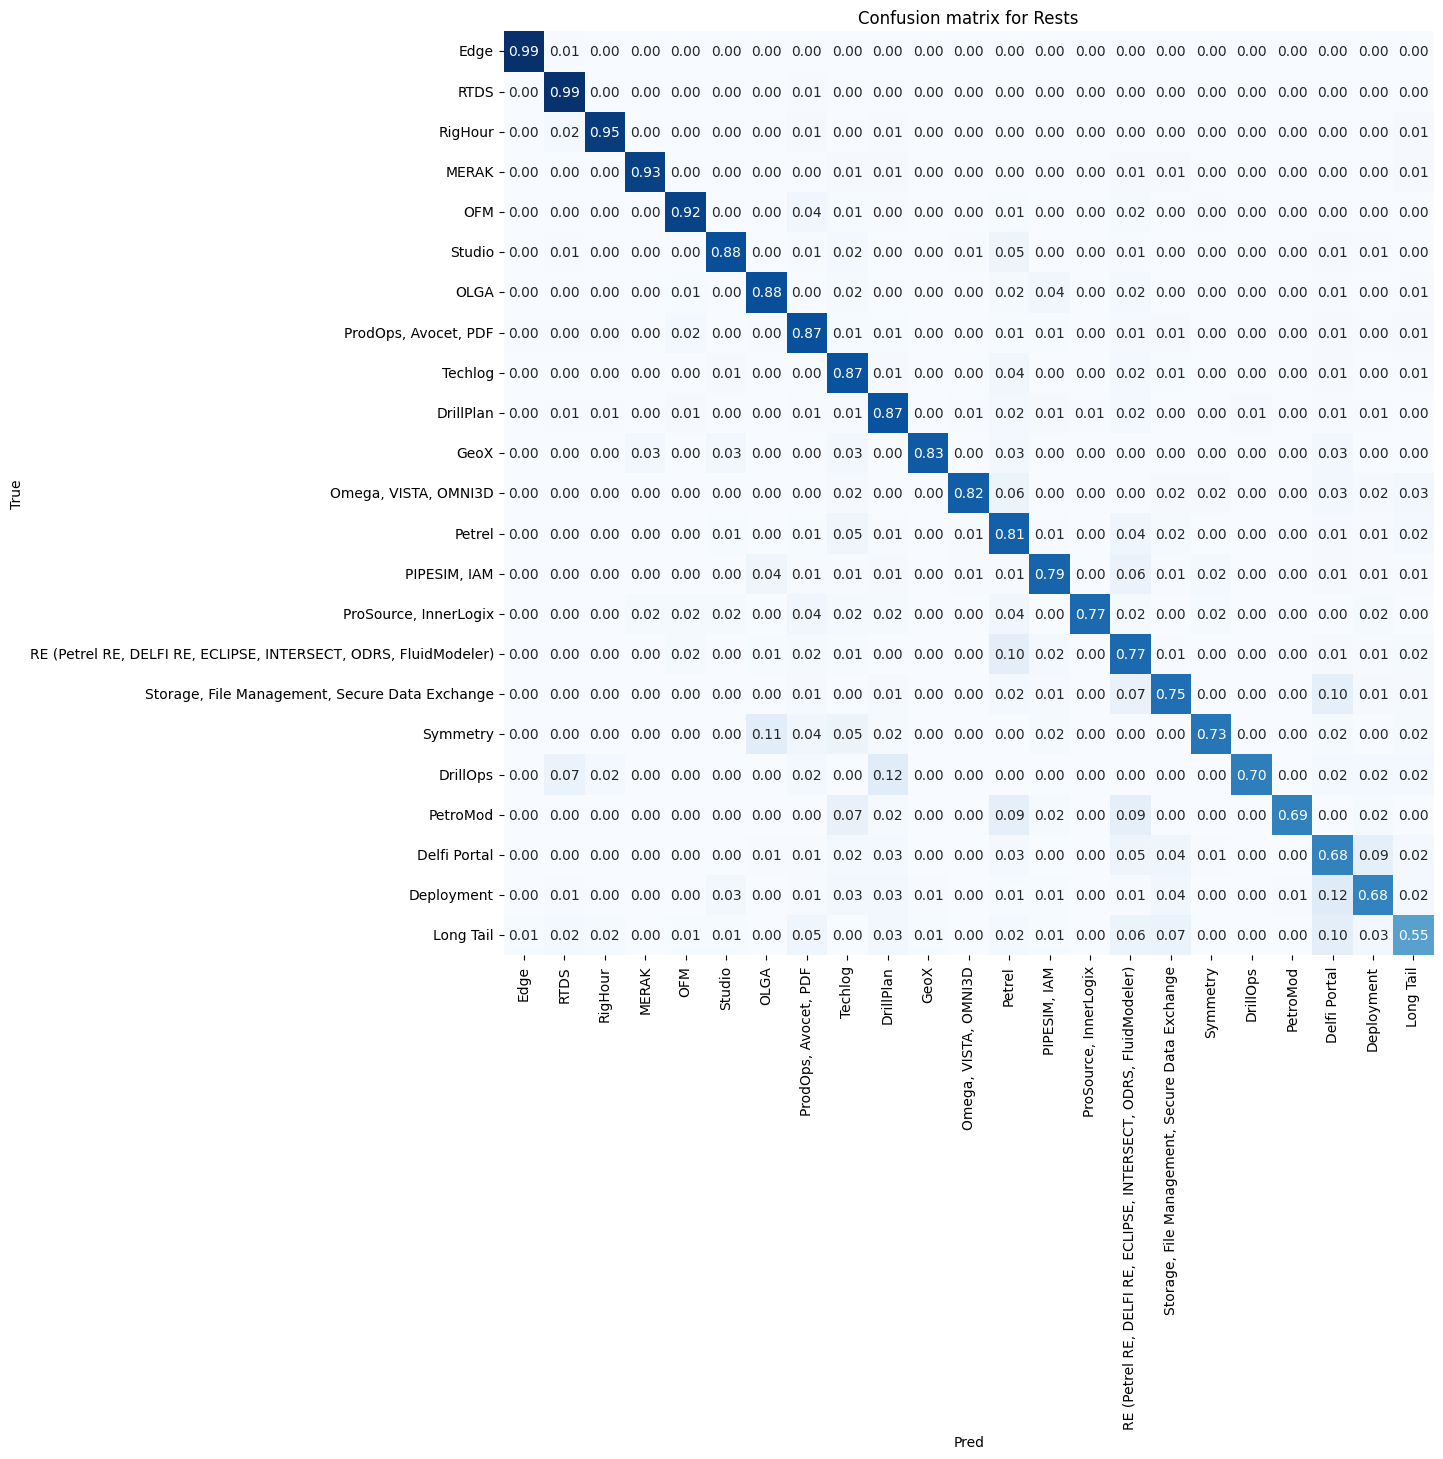

Accuracy of top 1 prediction is 0.829.
Accuracy of top 3 prediction is 0.925.
Accuracy of top 5 prediction is 0.952.


In [216]:
# Create and train the best Logistic Regression model
best_model_sgc = SGDClassifier(**best_params)
best_model_sgc.fit(X_train_encoded, y_train)

# Predict categories for the test data
y_pred_sgc = best_model_sgc.predict(X_test_encoded)

accuracy = accuracy_score(y_test, y_pred_sgc)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

# Evaluate the classifier's performance
print(classification_report(y_test, y_pred_sgc, digits=3))
plot_confusion_matrix(y_test, y_pred_sgc, title='Confusion matrix for Rests')
df_pred_top5_sgc = top5_accuracy_report(best_model_sgc, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [208]:
# Accuracy of top 1 prediction is 0.828.
# Accuracy of top 3 prediction is 0.926.
# Accuracy of top 5 prediction is 0.952.
# export the model
pickle.dump(best_model_sgc, open(f'{MODEL_FOLDER_PATH}/model_sgc_classifier.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_sgc_classifier.pkl', 'wb'))

## Logistic Classification (5min)

In [217]:
# Clean up the study if it exists
study_name = 'logReg'
storage_name = 'sqlite:///optuna_study.db'
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass 

In [226]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga', 'sag']),
        'C': trial.suggest_float('C', 1e-2, 1e+2, log=True),
        'penalty': 'l2',
        'multi_class': 'ovr',
        'max_iter': 50000,
        'random_state': 42
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    logReg = LogisticRegression(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(logReg, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)

study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-30 21:20:20,750] Using an existing study with name 'logReg' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-10-30 21:21:05,431] Trial 27 finished with value: 0.8165791202820847 and parameters: {'solver': 'saga', 'C': 3.2291839038621504}. Best is trial 2 with value: 0.8187165447943808.
[I 2023-10-30 21:21:13,950] Trial 22 finished with value: 0.8179817864704753 and parameters: {'solver': 'saga', 'C': 4.327000655338499}. Best is trial 2 with value: 0.8187165447943808.
[I 2023-10-30 21:21:14,046] Trial 28 finished with value: 0.817948391913788 and parameters: {'solver': 'saga', 'C': 4.375993312190604}. Best is trial 2 with value: 0.8187165447943808.
[I 2023-10-30 21:21:14,998] Trial 20 finished with value: 0.8179149917801876 and parameters: {'solver': 'saga', 'C': 4.345688447817167}. Best is trial 2 with value: 0.8187165447943808.
[I 2023-10-30 21:21:15,886] Trial 23 finished with value: 0.8180485811607632 and parameters: {'solver': 'saga', 'C': 4.543742300563612}. Best is trial 2 with value: 0.8187165447943808.
[I 2023-10-30 21:21:16,618] Trial 26 finished with value: 0.817948391913788

In [223]:
vis.plot_optimization_history(study)

In [224]:
vis.plot_slice(study)

Accuracy: 0.8224
                                                                  precision    recall  f1-score   support

                                                    Delfi Portal      0.711     0.697     0.704       300
                                                      Deployment      0.713     0.702     0.708       181
                                                        DrillOps      0.879     0.674     0.763        43
                                                       DrillPlan      0.790     0.848     0.818       164
                                                            Edge      0.984     0.989     0.986       184
                                                            GeoX      0.926     0.833     0.877        30
                                                 InterACT Inside      0.000     0.000     0.000         0
                                                       Long Tail      0.596     0.504     0.546       135
                            

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



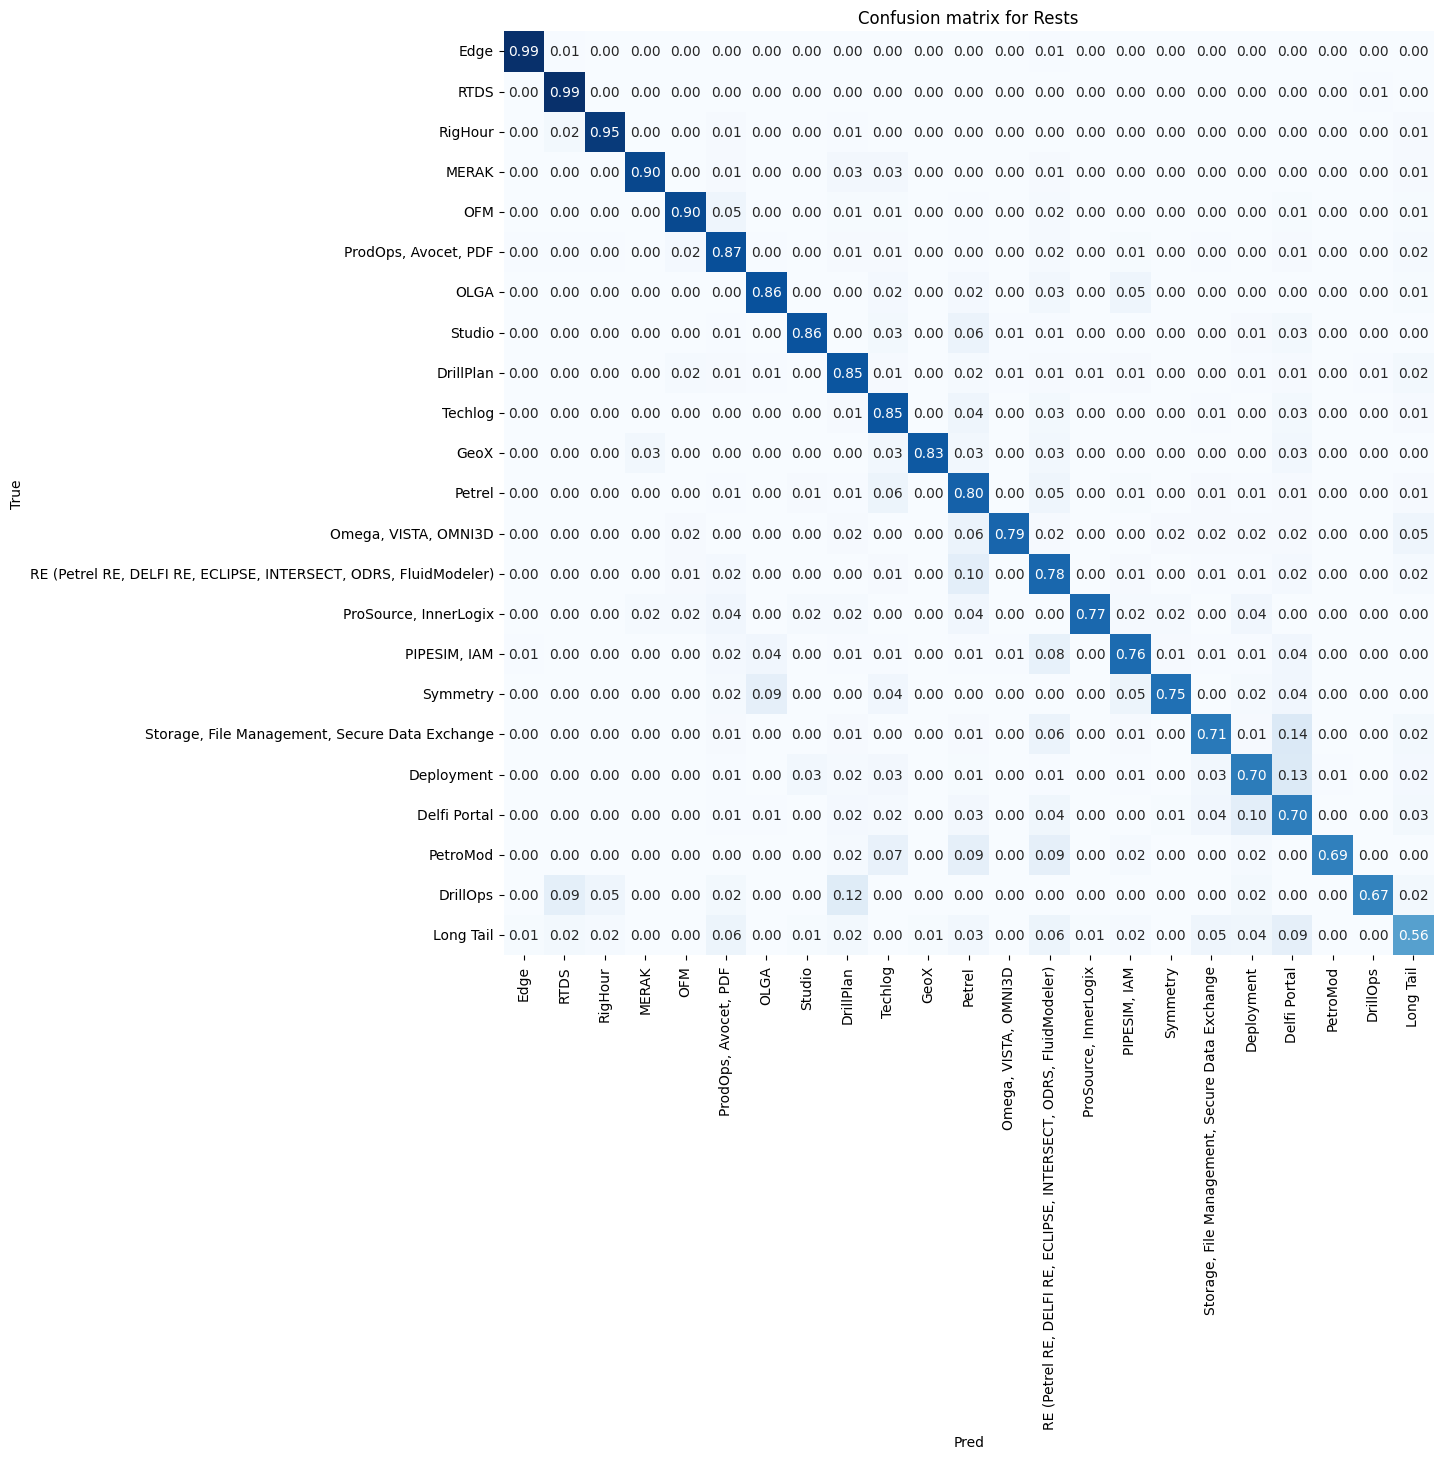

Accuracy of top 1 prediction is 0.822.
Accuracy of top 3 prediction is 0.932.
Accuracy of top 5 prediction is 0.960.


In [225]:
# Create and train the best Logistic Regression model
best_model_logReg= LogisticRegression(**best_params)
best_model_logReg.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_logReg = best_model_logReg.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_logReg)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_logReg, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_logReg, title='Confusion matrix for Rests')
df_pred_top5_logReg = top5_accuracy_report(best_model_logReg, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [160]:
# Accuracy of top 1 prediction is 0.817.
# Accuracy of top 3 prediction is 0.934.
# Accuracy of top 5 prediction is 0.961.
# export the model
pickle.dump(best_model_logReg, open(f'{MODEL_FOLDER_PATH}/model_logistic_regression.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_logistic_regression.pkl', 'wb'))

## MultinomialNB (2min)

In [227]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space of MultinomialNB model
    pamams = {
        'alpha': trial.suggest_float('alpha', 1e-6, 1e+2, log=True),
        'fit_prior': trial.suggest_categorical('fit_prior', [True, False])
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_multinomialNB = MultinomialNB(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_multinomialNB, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=250, 
    n_jobs=-1, 
    show_progress_bar=True,
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

# Create and train the best Logistic Regression model
best_model_multinomialNB = MultinomialNB(**best_params)
best_model_multinomialNB.fit(X_train_encoded, y_train)
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-10-30 21:21:36,990] A new study created in memory with name: no-name-ed08a909-57aa-4a77-b537-6f4e1ea893ed


  0%|          | 0/250 [00:00<?, ?it/s]

[I 2023-10-30 21:21:39,112] Trial 0 finished with value: 0.7641107951975638 and parameters: {'alpha': 0.020778151031917363, 'fit_prior': True}. Best is trial 0 with value: 0.7641107951975638.
[I 2023-10-30 21:21:39,142] Trial 2 finished with value: 0.7209274005237614 and parameters: {'alpha': 2.0830536050403768e-05, 'fit_prior': True}. Best is trial 0 with value: 0.7641107951975638.
[I 2023-10-30 21:21:39,579] Trial 4 finished with value: 0.7387618282147865 and parameters: {'alpha': 0.0009865872780650598, 'fit_prior': True}. Best is trial 0 with value: 0.7641107951975638.
[I 2023-10-30 21:21:39,587] Trial 1 finished with value: 0.6828533507154566 and parameters: {'alpha': 3.8160938126996884, 'fit_prior': True}. Best is trial 0 with value: 0.7641107951975638.
[I 2023-10-30 21:21:39,640] Trial 8 finished with value: 0.7562956212419272 and parameters: {'alpha': 0.008369143864648577, 'fit_prior': True}. Best is trial 0 with value: 0.7641107951975638.
[I 2023-10-30 21:21:39,671] Trial 5 fin

Accuracy: 0.789460
                                                                  precision    recall  f1-score   support

                                                    Delfi Portal      0.676     0.667     0.671       300
                                                      Deployment      0.703     0.707     0.705       181
                                                        DrillOps      0.793     0.535     0.639        43
                                                       DrillPlan      0.686     0.878     0.770       164
                                                            Edge      0.957     0.973     0.965       184
                                                            GeoX      0.955     0.700     0.808        30
                                                 InterACT Inside      0.000     0.000     0.000         0
                                                       Long Tail      0.595     0.370     0.457       135
                          

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



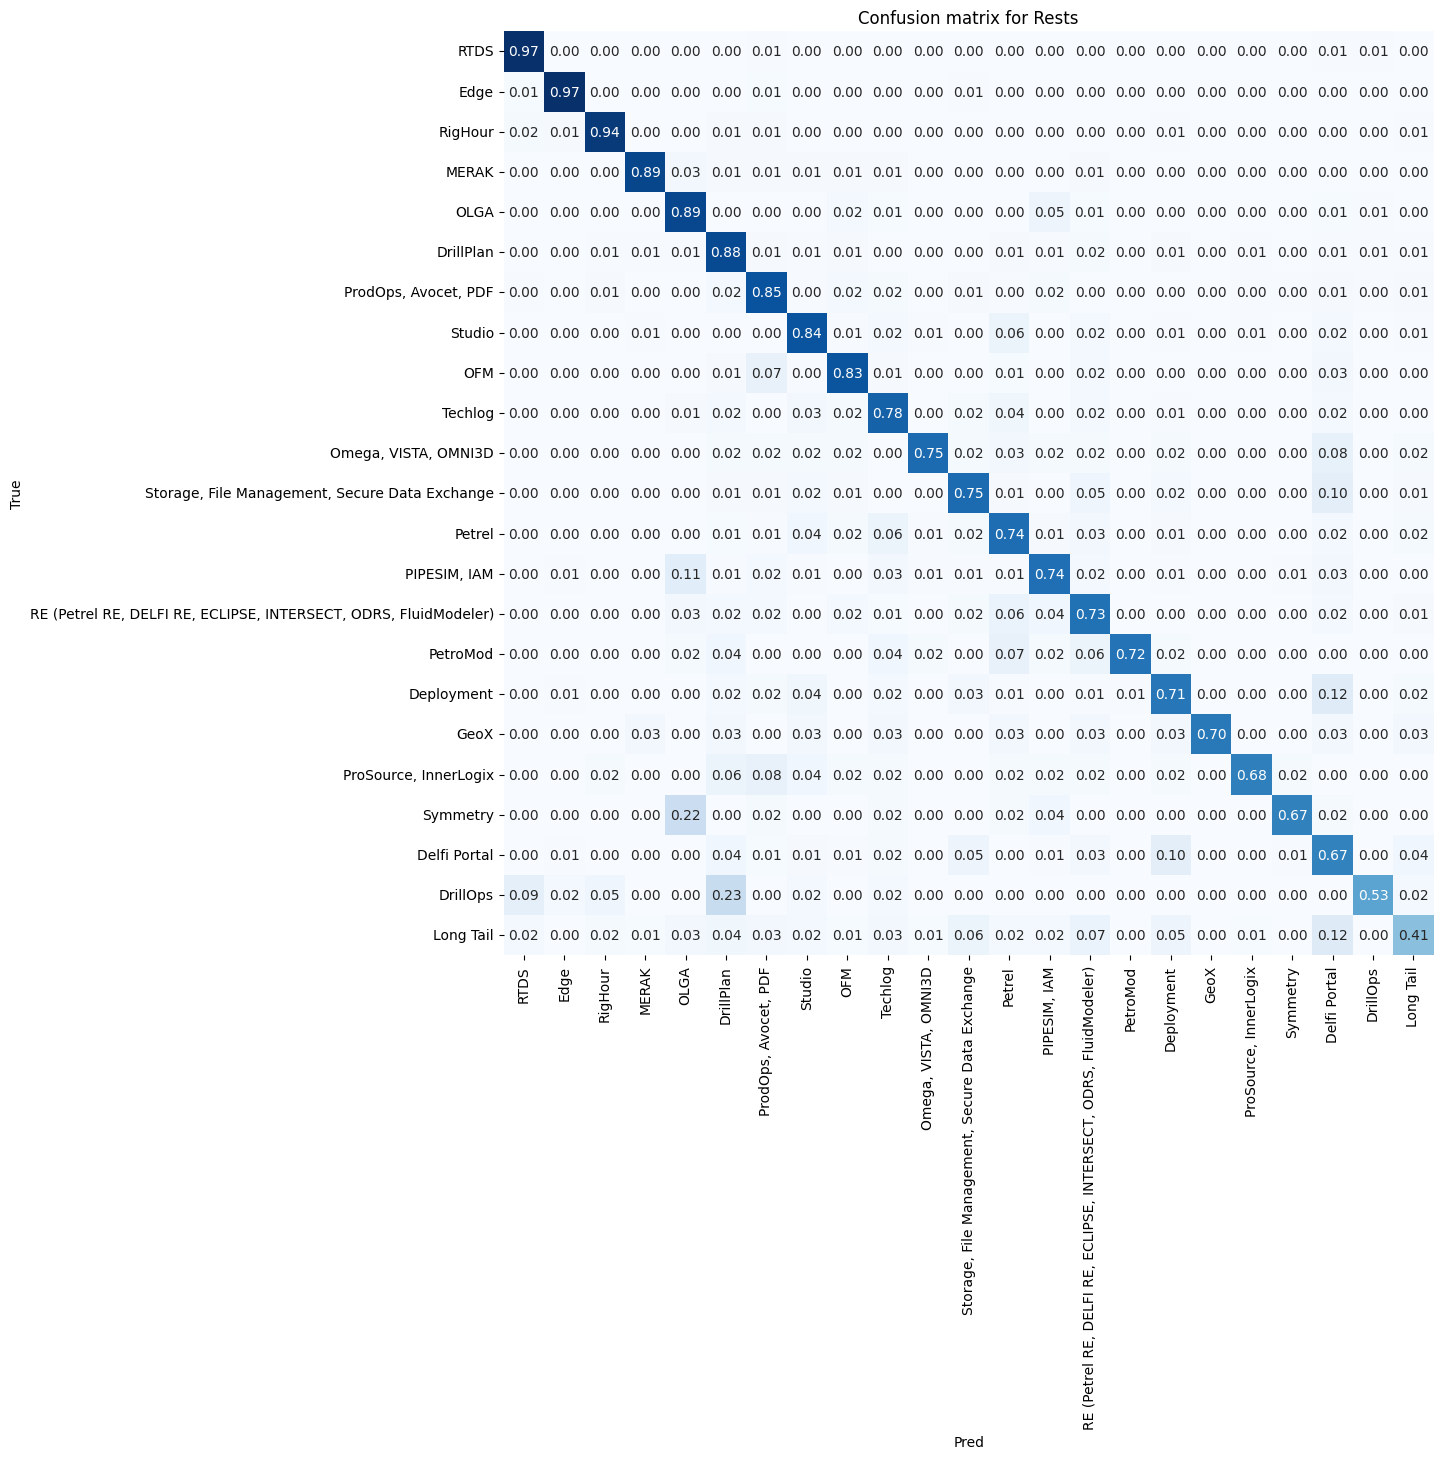

Accuracy of top 1 prediction is 0.789.
Accuracy of top 3 prediction is 0.927.
Accuracy of top 5 prediction is 0.956.


In [228]:
# weights = df_rests['ProductName'].value_counts().apply(np.sqrt).to_dict()
model_multinomialNB = best_model_multinomialNB

# Step 4: Model Evaluation
y_pred_multinomialNB = model_multinomialNB.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_multinomialNB)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_multinomialNB, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_multinomialNB, title='Confusion matrix for Rests')
df_pred_top5_multinomialNB = top5_accuracy_report(model_multinomialNB, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [229]:
# Accuracy of top 1 prediction is 0.789.
# Accuracy of top 3 prediction is 0.927.
# Accuracy of top 5 prediction is 0.956.
# export the model and the vectorizer
pickle.dump(best_model_multinomialNB, open(f'{MODEL_FOLDER_PATH}/model_multinomialNB.pkl', 'wb'))
pickle.dump(vectorizer_countvec, open(f'{MODEL_FOLDER_PATH}/vectorizer_multinomialNB.pkl', 'wb'))

## SVC Linear (>60min)

In [230]:
# user Optuna to tune the hyperparameters for SVC Linear
study_name = 'SVC_linear'
storage_name = 'sqlite:///optuna_study.db'

# Clean up the study if it exists
try:
    optuna.delete_study(study_name=study_name, storage=storage_name)
except:
    pass

In [238]:
# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'C': trial.suggest_float('C', 1, 2, log=True),
        'max_iter': 50000,
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_svc_linear = SVC(kernel='linear', probability=True, **pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_svc_linear, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value

print("Best Hyperparameters:", best_params)

# Create and train the best Logistic Regression model
best_model_svc_linear = SVC(kernel='linear', **best_params)
best_model_svc_linear.fit(X_train_encoded, y_train)

[I 2023-10-30 22:17:59,069] Using an existing study with name 'SVC_linear' instead of creating a new one.


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-10-30 22:37:14,827] Trial 20 finished with value: 0.8112353665978365 and parameters: {'C': 1.2896668527401116}. Best is trial 4 with value: 0.8115025620897273.
[I 2023-10-30 22:37:15,631] Trial 21 finished with value: 0.8112353665978365 and parameters: {'C': 1.286346226145802}. Best is trial 4 with value: 0.8115025620897273.
[I 2023-10-30 22:37:16,385] Trial 22 finished with value: 0.8112353665978365 and parameters: {'C': 1.2891500621899221}. Best is trial 4 with value: 0.8115025620897273.
[I 2023-10-30 22:37:17,043] Trial 29 finished with value: 0.8110349379116668 and parameters: {'C': 1.3442094186550737}. Best is trial 4 with value: 0.8115025620897273.
[I 2023-10-30 22:37:17,057] Trial 24 finished with value: 0.8112019664642359 and parameters: {'C': 1.2888958666095907}. Best is trial 4 with value: 0.8115025620897273.
[I 2023-10-30 22:37:47,518] Trial 27 finished with value: 0.8112353665978365 and parameters: {'C': 1.2897707011092752}. Best is trial 4 with value: 0.81150256208

SVC(C=1.1973851350953848, kernel='linear')

In [239]:
vis.plot_optimization_history(study)

In [240]:
vis.plot_slice(study)

Accuracy: 0.817282
                                                                  precision    recall  f1-score   support

                                                    Delfi Portal      0.668     0.690     0.679       300
                                                      Deployment      0.753     0.657     0.702       181
                                                        DrillOps      0.857     0.698     0.769        43
                                                       DrillPlan      0.757     0.872     0.810       164
                                                            Edge      0.989     0.989     0.989       184
                                                            GeoX      0.893     0.833     0.862        30
                                                 InterACT Inside      0.000     0.000     0.000         0
                                                       Long Tail      0.638     0.496     0.558       135
                          

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



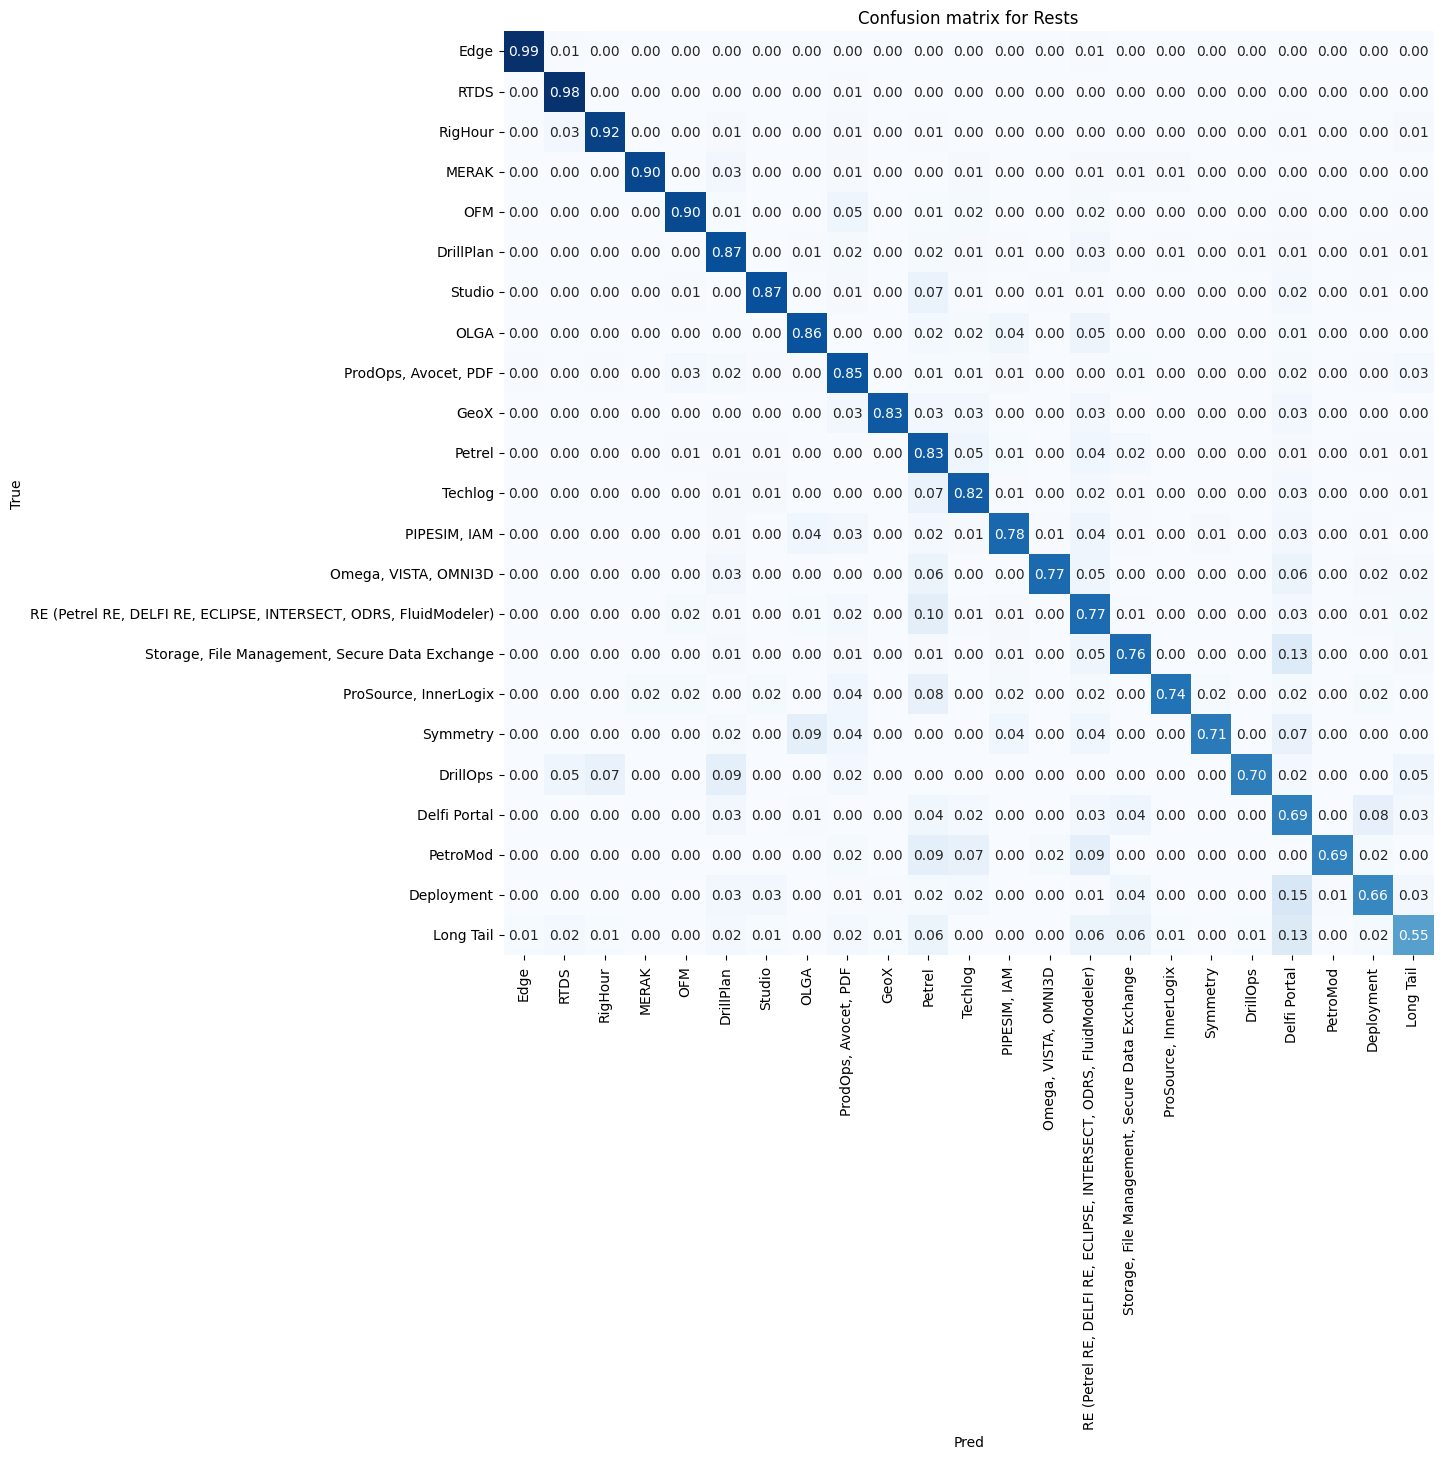

Accuracy of top 1 prediction is 0.821.
Accuracy of top 3 prediction is 0.935.
Accuracy of top 5 prediction is 0.965.


In [234]:
best_model_svc_linear = SVC(kernel='linear', probability=True, **best_params)
# best_model_svc_linear = SVC(kernel='linear', probability=True)
best_model_svc_linear.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_svc_linear = best_model_svc_linear.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_svc_linear)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_svc_linear, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_svc_linear, title='Confusion matrix for Rests')
df_pred_top5_svc_linear = top5_accuracy_report(best_model_svc_linear, vectorizer_tfidf, X_test, y_test, pre_processed=True)

In [170]:
# Accuracy of top 1 prediction is 0.816.
# Accuracy of top 3 prediction is 0.935.
# Accuracy of top 5 prediction is 0.964.
pickle.dump(best_model_svc_linear, open(f'{MODEL_FOLDER_PATH}/model_svc_linear.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_svc_linear.pkl', 'wb'))

## RandomForestClassifier

In [ ]:
# user Optuna to tune the hyperparameters for RandomForestClassifier

# Define an objective function to optimize
def objective(trial):

    # Define hyperparameter search space

    pamams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 4000, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        # 'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        # 'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'random_state': 42,
    }
    
    # Create and train the SGD Classifier with suggested hyperparameters
    model_random_forest = RandomForestClassifier(**pamams)

    # Evaluate the model on the validation set
    scores = cross_val_score(model_random_forest, X_train_encoded, y_train, cv=5, scoring='accuracy')

    return np.mean(scores)

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(
    objective,
    n_trials=10, 
    n_jobs=-1, 
    show_progress_bar=True
    )  # You can adjust the number of trials

# Print the best hyperparameters and corresponding accuracy
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)

best_model_random_forest = RandomForestClassifier(**best_params)
best_model_random_forest.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_random_forest = best_model_random_forest.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred_random_forest)
print(f'Accuracy: \033[94m{accuracy:4f}\033[0m')

report = classification_report(y_test, y_pred_random_forest, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_random_forest, title='Confusion matrix for Rests')
df_pred_top5_random_forest = top5_accuracy_report(best_model_random_forest, vectorizer_tfidf, X_test, y_test, pre_processed=True)

pickle.dump(best_model_random_forest, open(f'{MODEL_FOLDER_PATH}/model_random_forest.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_random_forest.pkl', 'wb'))

## Voting model

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8237
                                                                  precision    recall  f1-score   support

                                                    Delfi Portal      0.697     0.690     0.693       300
                                                      Deployment      0.747     0.685     0.715       181
                                                        DrillOps      0.919     0.791     0.850        43
                                                       DrillPlan      0.803     0.872     0.836       164
                                                            Edge      0.978     0.989     0.984       184
                                                            GeoX      0.867     0.867     0.867        30
                                                 InterACT Inside      0.000     0.000     0.000         0
                                                       Long Tail      0.733     0.489     0.587       135
                            

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

/Users/haitao/.pyenv/versions/3.11.6/envs/TFT/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



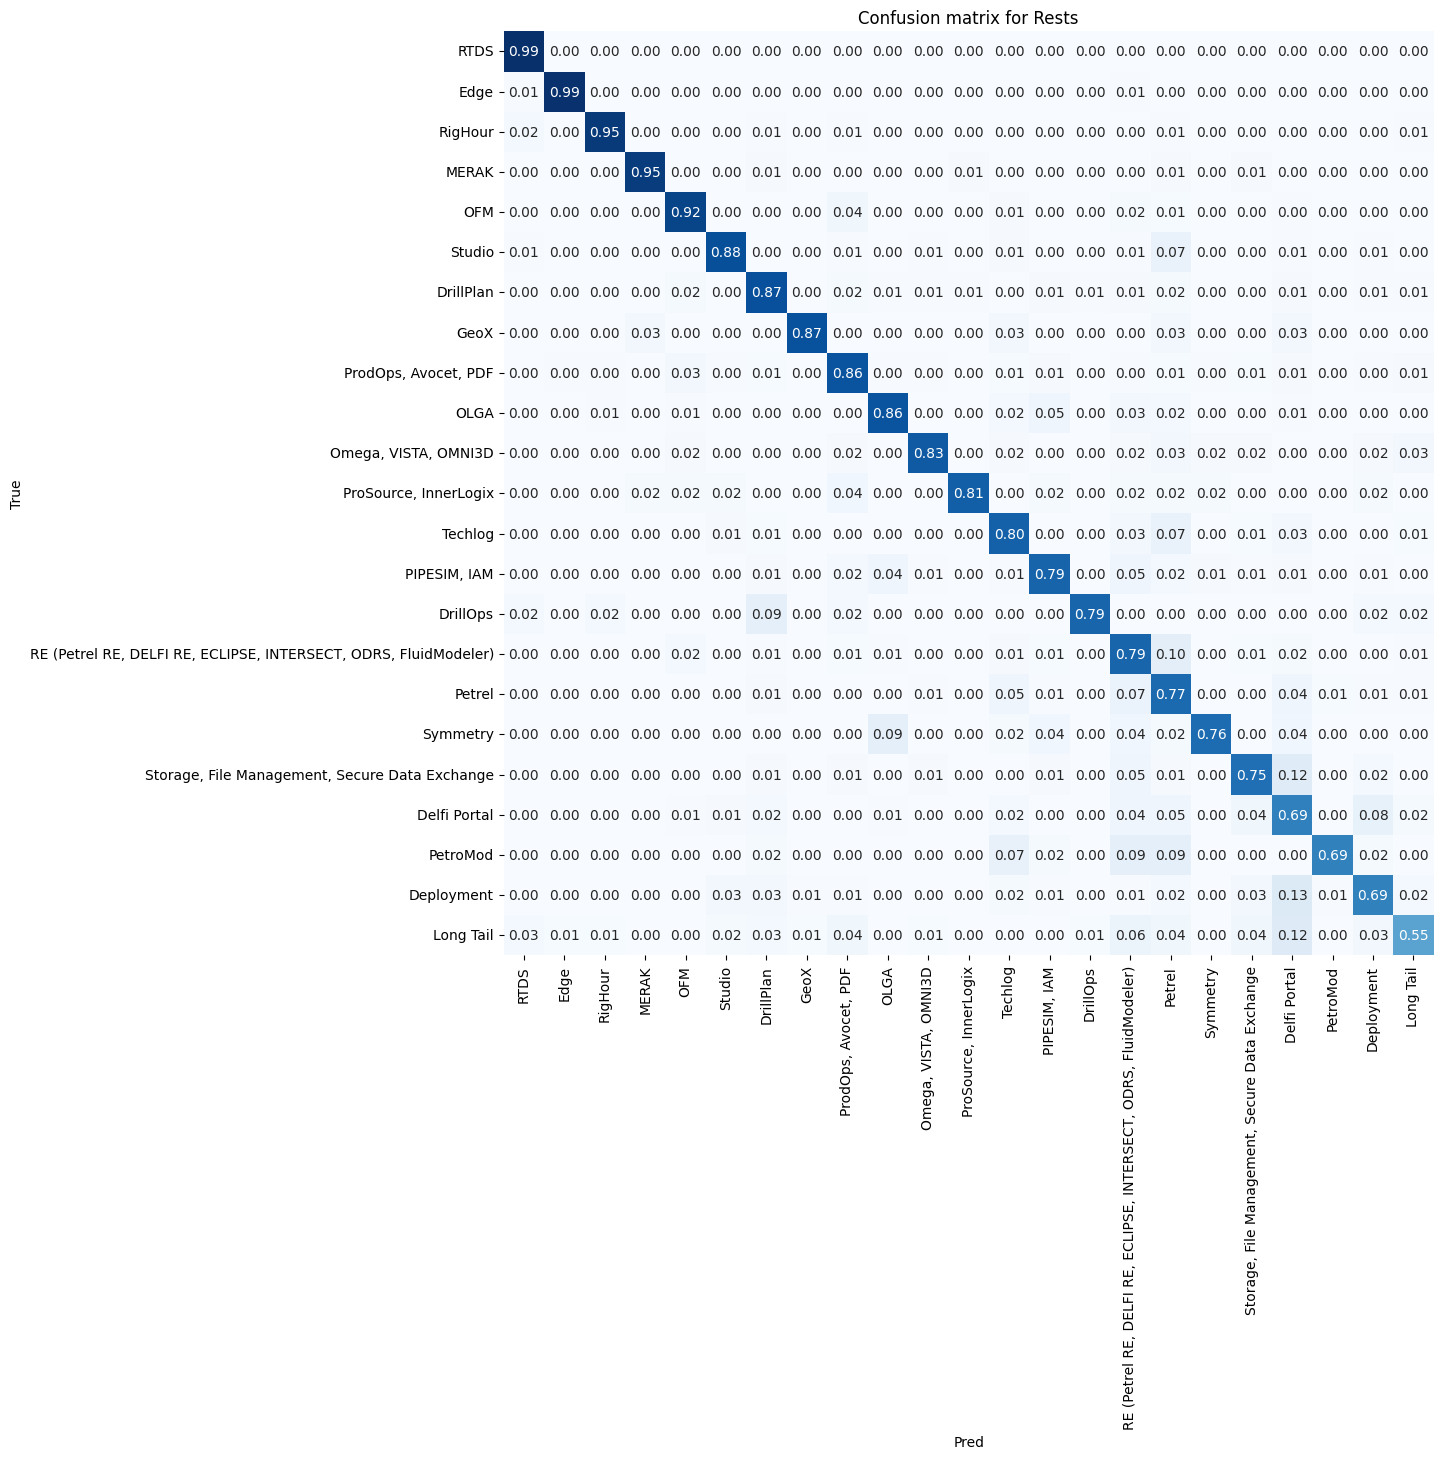

Accuracy of top 1 prediction is 0.824.
Accuracy of top 3 prediction is 0.936.
Accuracy of top 5 prediction is 0.963.


In [175]:
# now we have three models, logistic regression, multinomialNB and svc_linear, we can use voting classifier to combine them together
from sklearn.ensemble import VotingClassifier

# Create a dictionary of the models
estimators = [
    ('logReg', best_model_logReg),
    ('svc_linear', best_model_svc_linear),
    ('sgc_classifier', best_model_sgc),
]

# Create a voting classifier
voting = VotingClassifier(estimators, voting='soft', n_jobs=-1)

# Fit the voting classifier to the training data
voting.fit(X_train_encoded, y_train)

# Step 4: Model Evaluation
y_pred_voting = voting.predict(X_test_encoded)
accuracy = accuracy_score(y_test, y_pred_voting)
print(f'Accuracy: \033[94m{accuracy:.4f}\033[0m')

report = classification_report(y_test, y_pred_voting, digits=3)
print(report)

plot_confusion_matrix(y_test, y_pred_voting, title='Confusion matrix for Rests')

df_pred_top5_voting = top5_accuracy_report(voting, vectorizer, X_test, y_test, pre_processed=True)

In [176]:
# Accuracy of top 1 prediction is 0.824.
# Accuracy of top 3 prediction is 0.936.
# Accuracy of top 5 prediction is 0.963.
pickle.dump(voting, open(f'{MODEL_FOLDER_PATH}/model_voting.pkl', 'wb'))
pickle.dump(vectorizer_tfidf, open(f'{MODEL_FOLDER_PATH}/vectorizer_voting.pkl', 'wb'))